# Predicting Relevance
We explore the potential to classify articles according to their relevance

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
from collections import Counter
import shifterator as sh

In [2]:
df = pd.read_csv("manual_annotations_sample.csv")
df

,id,title,author,year,outlet,type,abstract,relevant
0,14133,Analysis of the feelings of the population's o...,"Kwecko, Viviani; de Toledo, Fernando P.; Devin...",2020,2020 IEEE FRONTIERS IN EDUCATION CONFERENCE (F...,Proceedings Paper,This research presents a work in which we iden...,1
1,1578,Sentiment Analysis Meets Explainable Artificia...,"Diwali, Arwa (57837467700); Saeedi, Kawther (3...",2023,IEEE Transactions on Affective Computing,Article,Sentiment analysis can be used to derive knowl...,0
2,12488,Deep Learning Based Sentiment Analysis On COVI...,"Mengistie, Tajebe Tsega; Kumar, Deepak",2021,3RD INTERNATIONAL CONFERENCE ON ARTIFICIAL INT...,Proceedings Paper,Sentiment Analysis is a classification task in...,1
3,14258,Exploring online customer engagement with hosp...,"Bilro, Ricardo Godinho; Correia Loureiro, Sand...",2019,JOURNAL OF HOSPITALITY MARKETING & MANAGEMENT,Article,Opinions published online about a given experi...,1
4,512,Multimodal Interaction and Fused Graph Convolu...,"Zeng, Dehong (58295185500); Chen, Xiaosong (58...",2023,Mathematics,Article,An increasing number of people tend to convey ...,1
...,...,...,...,...,...,...,...,...
997,12524,Establishing News Credibility using Sentiment ...,"Sharf, Zareen; Jalil, Zakia; Amir, Wajiha; Sid...",2019,INTERNATIONAL JOURNAL OF ADVANCED COMPUTER SCI...,Article,The widespread use of Internet has resulted in...,1
998,14343,Leveraging Just a Few Keywords for Fine-Graine...,"Karamanolakis, Giannis; Hsu, Daniel; Gravano, ...",2019,2019 CONFERENCE ON EMPIRICAL METHODS IN NATURA...,Proceedings Paper,User-generated reviews can be decomposed into ...,0
999,4,AlgBERT: Automatic Construction of Annotated C...,"Hamadouche, Khaoula (58106714400); Bousmaha, K...",2023,ACM Transactions on Asian and Low-Resource Lan...,Article,"Nowadays, sentiment analysis is one of the mos...",1
1000,11568,On Vietnamese Sentiment Analysis: A Transfer L...,Ngoc C Le; Nguyen The Lam; Son Hong Nguyen; Du...,2020,2020 RIVF INTERNATIONAL CONFERENCE ON COMPUTIN...,Proceedings Paper,Sentiment analysis (also known as opinion mini...,1


In [3]:
traindf, testdf = train_test_split(df, random_state=1983)
testdf = testdf.dropna()

## Step 1: Baseline: CountVectorizer + Naive Bayes

In [4]:
model1 = make_pipeline(CountVectorizer(), MultinomialNB())

In [5]:
model1.fit(traindf['abstract'], traindf['relevant'])
y_pred = model1.predict(testdf['abstract'])
print(classification_report(testdf['relevant'], y_pred))

              precision    recall  f1-score   support

           0       0.77      0.51      0.61       115
           1       0.68      0.87      0.76       135

    accuracy                           0.70       250
   macro avg       0.72      0.69      0.69       250
weighted avg       0.72      0.70      0.69       250



That's quite good already, we could already use this!

## Step 2: Better Models
We played a bit around and settled on a support vector machine

In [6]:
pipeline = Pipeline(
    steps=[
        ("vectorizer", TfidfVectorizer()),
        ("classifier", SVC()),
    ]
)
grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__max_df": [0.5, 1.0],
    "vectorizer__min_df": [1, 5],
    "classifier__kernel" : ['linear', 'rbf', 'poly'],
    "classifier__C": [0.01, 1, 100, 1000],
}
search = GridSearchCV(
    estimator=pipeline, n_jobs=-1, param_grid=grid, scoring="f1", cv=5
)
search.fit(traindf['abstract'], traindf['relevant'])

print(f"Best parameters: {search.best_params_}")
y_pred = search.predict(testdf['abstract'])
print(classification_report(testdf['relevant'], y_pred))

Best parameters: {'classifier__C': 100, 'classifier__kernel': 'rbf', 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.81      0.45      0.58       115
           1       0.66      0.91      0.77       135

    accuracy                           0.70       250
   macro avg       0.74      0.68      0.67       250
weighted avg       0.73      0.70      0.68       250



In [7]:
## Step 3: Explore the mistakes

In [8]:
testdf['y_pred'] = y_pred
testdf.to_excel('check.xlsx')

### Visualize most characteristic words for the errors

In [9]:
fp = testdf.query("relevant==0 and y_pred==1")
fn = testdf.query("relevant==1 and y_pred==0")
tp = testdf.query("relevant==1 and y_pred==1")
tn = testdf.query("relevant==0 and y_pred==0")

In [10]:
type2freq_1 = Counter(" ".join(fp['abstract'].to_list()).lower().split())
type2freq_2 = Counter(" ".join(tp['abstract'].to_list()).lower().split())

/home/damian/.local/lib/python3.10/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


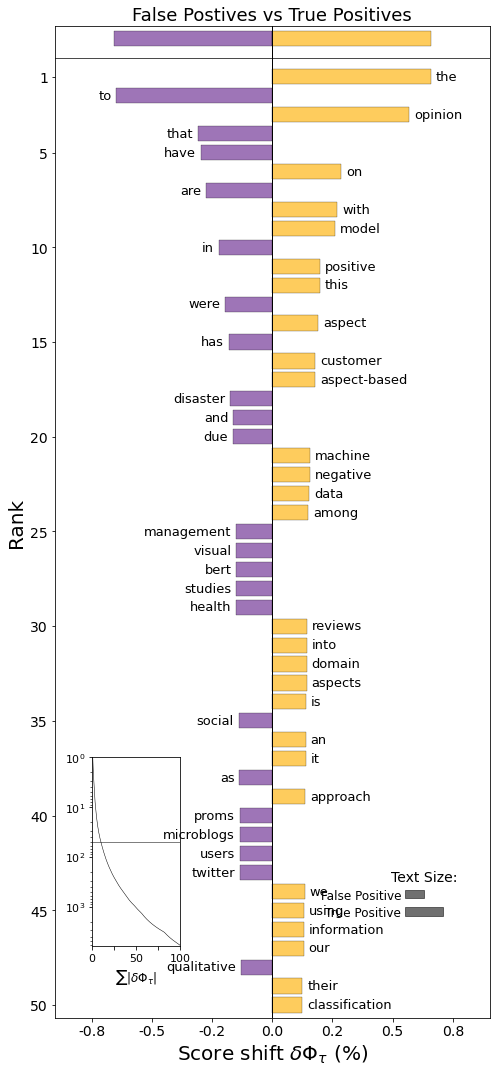

<AxesSubplot:title={'center':'False Postives vs True Positives'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [11]:
type2freq_1 = Counter(" ".join(fp['abstract'].to_list()).lower().split())
type2freq_2 = Counter(" ".join(tp['abstract'].to_list()).lower().split())

proportion_shift = sh.ProportionShift(type2freq_1=type2freq_1,
                                      type2freq_2=type2freq_2)
proportion_shift.get_shift_graph(system_names = ['False Positive', 'True Positive'],
                                 title='False Postives vs True Positives')



/home/damian/.local/lib/python3.10/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


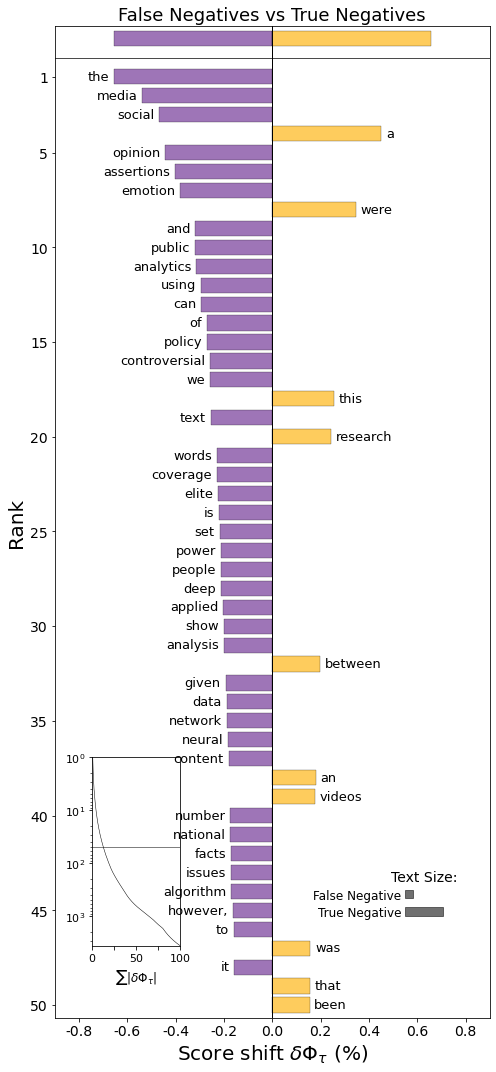

<AxesSubplot:title={'center':'False Negatives vs True Negatives'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [12]:
type2freq_1 = Counter(" ".join(fn['abstract'].to_list()).lower().split())
type2freq_2 = Counter(" ".join(tn['abstract'].to_list()).lower().split())

proportion_shift = sh.ProportionShift(type2freq_1=type2freq_1,
                                      type2freq_2=type2freq_2)
proportion_shift.get_shift_graph(system_names = ['False Negative', 'True Negative'],
                                 title='False Negatives vs True Negatives')



# Conclusion

- Given a recall of .91 using the SVM sounds like a very good idea. The precision of 66% is acceptable - kicking out one third by hand seems OK.
- It's hard to really put a finger on where the errors lie - some observations make sense, others less